In [121]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

import astropy
from astropy import stats
import math

import scipy
from scipy import stats

from numpy import (isscalar, r_, log, around, unique, asarray, zeros,
                   arange, sort, amin, amax, atleast_1d, sqrt, array,
                   compress, pi, exp, ravel, count_nonzero, sin, cos,
                   arctan2, hypot)


from scipy import optimize
from scipy import special

import figurefirst as fifi
import time

# Step 1: Calculate max change at various lags

In [11]:
def maxchange_std (df, startval, lagarray, method='forward'):
    
    d_list=np.zeros((len(lagarray)))
    j=0
    
    def checkforwardbounds(df,startval,lag):
        if (startval+i)>=len(df):
            raise ValueError('Lag value extends beyond length of timeseries')            
    
    def checkbackwardbounds(df,startval,lag):
        if (startval-i)<0:
            raise ValueError('Lag value extends beyond length of timeseries')  

    
    for i in lagarray:
        
        if method=='forward':
            checkforwardbounds(df,startval,i)
            b=df.iloc[startval:startval+i]
            std= mycircstd(b, high=360, low=0) 
            d_list[j]=std
                
        j+=1
    return d_list

In [12]:
def _circfuncs_common(samples, high, low, nan_policy='propagate'):
    # Ensure samples are array-like and size is not zero
    samples = np.asarray(samples)
    if samples.size == 0:
        return np.nan, np.asarray(np.nan), np.asarray(np.nan), None

    # Recast samples as radians that range between 0 and 2 pi and calculate
    # the sine and cosine
    sin_samp = sin((samples - low)*2.*pi / (high - low))
    cos_samp = cos((samples - low)*2.*pi / (high - low))
    #sin_samp=sin(samples)
    #cos_samp=cos(samples)
    mask = None
    return samples, sin_samp, cos_samp, mask


def mycircstd(samples, high=360, low=0, axis=None, nan_policy='propagate'):

    samples, sin_samp, cos_samp, mask = _circfuncs_common(samples, high, low,
                                                          nan_policy=nan_policy)
    if mask is None:
        sin_mean = sin_samp.mean(axis=axis)  # [1] (2.2.3)
        cos_mean = cos_samp.mean(axis=axis)  # [1] (2.2.3)
    else:
        nsum = np.asarray(np.sum(~mask, axis=axis).astype(float))
        nsum[nsum == 0] = np.nan
        sin_mean = sin_samp.sum(axis=axis) / nsum
        cos_mean = cos_samp.sum(axis=axis) / nsum
    # hypot can go slightly above 1 due to rounding errors
    with np.errstate(invalid='ignore'):
        R = np.minimum(1, hypot(sin_mean, cos_mean))  # [1] (2.2.4)

    #res = sqrt(-2*log(R))
    #if not normalize:
    #    res *= (high-low)/(2.*pi)  # [1] (2.3.14) w/ (2.3.7)
    res = np.sqrt(2 * (1 -R))
    
    return res

def maxchange_std (df, startval, lagarray, method='forward'):
    
    d_list=np.zeros((len(lagarray)))
    j=0
    
    def checkforwardbounds(df,startval,lag):
        if (startval+i)>=len(df):
            raise ValueError('Lag value extends beyond length of timeseries')            
    
    def checkbackwardbounds(df,startval,lag):
        if (startval-i)<0:
            raise ValueError('Lag value extends beyond length of timeseries')  

    
    for i in lagarray:
        
        if method=='forward':
            checkforwardbounds(df,startval,i)
            b=df.iloc[startval:startval+i]
            std= mycircstd(b, high=360, low=0) 
            d_list[j]=std
                
        j+=1
    return d_list


def vert_temporal_analysis (vertical_vel, horizontal_speed, horizontal_dir, lagarray, method='forward'):
    '''
# This function takes a single starting value from a column of directional data in a pandas df or np array
# and returns a list of values at each desired lag.

# Note, directional data must be between 0-360 degrees.
# Need to convert data if in radians and/or if it goes from -180 to 180.


#inputs: df - one column or array of directional data bounded between 0-360
#        startval - first point of wind data that you want to analyze
#        lagarray - array of time lags that you wish to calculate. a lag of 1=.1 sec
#        method - time direction in which lags are calculated 
#        options are forward, backward, average, max, or min. 
#             if no method is selected, forward is the default
    '''
    
    avg_vertical_vel_list=np.zeros((len(lagarray)))
    avg_horizontal_speed_list=np.zeros((len(lagarray)))
    avg_horizontal_dir_list=np.zeros((len(lagarray)))
    
    std_vertical_vel_list=np.zeros((len(lagarray)))
    std_horizontal_speed_list=np.zeros((len(lagarray)))
    std_horizontal_dir_list=np.zeros((len(lagarray)))
    j=0

    def fixangle(angle):
        if angle>=180:
            angle=360-angle
        return angle
    
    
    def checkforwardbounds(dir_df,startval,lag): 
    #compute the standard deviation backwards if the start value+lag will be greater than the length of the df
        if (startval+i)>=len(df): 
            
            vertchunk=vertical_vel.iloc[(startval-i):startval]
            horizontalchunk=horizontal_speed.iloc[(startval-i):startval]
            dirchunk=horizontal_dir.iloc[(startval-i):startval]
            
            avg_vertical_vel_list[j]= np.mean(vertchunk)
            avg_horizontal_speed_list[j]= np.mean(horizontalchunk)
            avg_horizontal_dir_list[j]=scipy.stats.circmean(dirchunk,high=360, low=0)
            
            std_vertical_vel_list[j]= np.std(vertchunk)
            std_horizontal_speed_list[j]=np.std(horizontalchunk)
            std_horizontal_dir_list[j]=mycircstd(dirchunk, high=360, low=0) 
               
    
    for i in lagarray:
        
        if method=='forward': #currently only forward - will eventually update?
            startval=int(vertical_vel.sample(1).index.to_numpy()) #get a random start value for each lag
            checkforwardbounds(vertical_vel,startval,i)
            vertchunk=vertical_vel.iloc[startval:(startval+i)]
            horizontalchunk=horizontal_speed.iloc[startval:(startval+i)]
            dirchunk=horizontal_dir.iloc[startval:(startval+i)]
            
            avg_vertical_vel_list[j]= np.mean(vertchunk)
            avg_horizontal_speed_list[j]= np.mean(horizontalchunk)
            avg_horizontal_dir_list[j]=scipy.stats.circmean(dirchunk,high=360, low=0)
            
            std_vertical_vel_list[j]= np.std(vertchunk)
            std_horizontal_speed_list[j]=np.std(horizontalchunk)
            std_horizontal_dir_list[j]=mycircstd(dirchunk, high=360, low=0) 
        
        j+=1
    return avg_vertical_vel_list, avg_horizontal_speed_list, avg_horizontal_dir_list, std_vertical_vel_list,std_horizontal_speed_list,std_horizontal_dir_list

In [4]:
df1=pd.read_hdf('raw_data_for_me/small_10.20.20_maskedgpsdata.hdf')
df2=pd.read_hdf('raw_data_for_me/small_7.7.21_maskedgpsdata.hdf')
df3=pd.read_hdf('raw_data_for_me/small_9.26.21_maskedgpsdata.hdf')
df4=pd.read_hdf('raw_data_for_me/small_10.29.21_maskedgpsdata.hdf')
df5=pd.read_hdf('raw_data_for_me/small_10.30.21_maskedgpsdata.hdf')
df6=pd.read_hdf('raw_data_for_me/small_1.8.22_maskedgpsdata.hdf')
df7=pd.read_hdf('raw_data_for_me/small_1.11.22_maskedgpsdata.hdf')
df8=pd.read_hdf('raw_data_for_me/small_1.15.22_maskedgpsdata.hdf')
df9=pd.read_hdf('raw_data_for_me/small_4.30.22_maskedgpsdata.hdf')
df10=pd.read_hdf('raw_data_for_me/small_5.1.22_maskedgpsdata.hdf')
df11=pd.read_hdf('raw_data_for_me/small_5.2.22_maskedgpsdata.hdf')
df12=pd.read_hdf('raw_data_for_me/small_6.1.22_maskedgpsdata.hdf')
df13=pd.read_hdf('raw_data_for_me/small_6.3.22_maskedgpsdata.hdf')
df14=pd.read_hdf('raw_data_for_me/small_6.7.22_maskedgpsdata.hdf')
df15=pd.read_hdf('raw_data_for_me/small_6.8.22_maskedgpsdata.hdf')
df16=pd.read_hdf('raw_data_for_me/small_6.22.22_maskedgpsdata.hdf')

# Calculate lags and make a df for each data collection

In [262]:
df=df16
time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(df.time.iloc[0]))

'2022-06-22 11:33:23'

In [263]:
print(df.keys())

Index(['time', 'S2_2', 'D_2', 'X_2', 'Y_2', 'Z_2', 'S2_3', 'D_3', 'X_3', 'Y_3',
       'Z_3', 'S2_4_verticallyorientated', 'D_4_verticallyorientated',
       'X_4_verticallyorientated', 'Y_4_verticallyorientated',
       'Z_4_verticallyorientated', 'S2_5', 'D_5', 'X_5', 'Y_5', 'Z_5', 'S2_6',
       'D_6', 'X_6', 'Y_6', 'Z_6', 'S2_7', 'D_7', 'X_7', 'Y_7', 'Z_7', 'S2_8',
       'D_8', 'X_8', 'Y_8', 'Z_8', 'S2_9_verticallyorientated',
       'D_9_verticallyorientated', 'X_9_verticallyorientated',
       'Y_9_verticallyorientated', 'Z_9_verticallyorientated',
       'U_4_verticallyorientated', 'V_4_verticallyorientated',
       'U_9_verticallyorientated', 'V_9_verticallyorientated'],
      dtype='object')


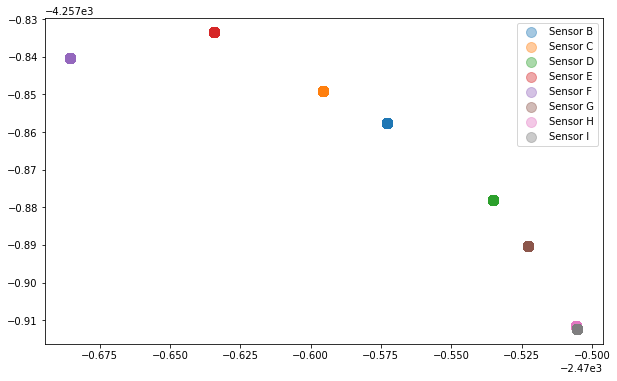

In [264]:
#get a sense of where sensors were located
#vertically oriented sensors were paired on a tripod with another sensor
#using this to determine which sensor to use for horizontal speed comparison
fig=plt.figure(figsize=(10,6))
#plt.scatter(df.X_1,df.Y_1, s=100, alpha=.4, label='Sensor A')
plt.scatter(df.X_2,df.Y_2, s=100, alpha=.4, label='Sensor B')
plt.scatter(df.X_3,df.Y_3, s=100, alpha=.4, label='Sensor C')
plt.scatter(df.X_4_verticallyorientated,df.Y_4_verticallyorientated, s=100, alpha=.4, label='Sensor D')
plt.scatter(df.X_5,df.Y_5, s=100, alpha=.4, label='Sensor E')
plt.scatter(df.X_6,df.Y_6, s=100, alpha=.4, label='Sensor F')
plt.scatter(df.X_7,df.Y_7, s=100, alpha=.4, label='Sensor G')
plt.scatter(df.X_8,df.Y_8, s=100, alpha=.4, label='Sensor H')
plt.scatter(df.X_9_verticallyorientated,df.Y_9_verticallyorientated, s=100, alpha=.4, label='Sensor I')
plt.legend()

In [265]:
loglags=np.arange(300,6300,300) #lags from 0-10mins, 30 sec intervals -- excluding lag zero since there is no standard dev over a period of 0

totalrows=np.arange(0,int(len(df)/10000))

avg_vert_U = np.empty((len(totalrows), 0)).tolist()
avg_s2 = np.empty((len(totalrows), 0)).tolist()
avg_d = np.empty((len(totalrows), 0)).tolist()
std_vert_U = np.empty((len(totalrows), 0)).tolist()
std_s2 = np.empty((len(totalrows), 0)).tolist()
std_d= np.empty((len(totalrows), 0)).tolist()

In [266]:
i=0
for j in totalrows:
    avg_vert_U[i], avg_s2[i], avg_d[i], std_vert_U[i], std_s2[i], std_d[i] = vert_temporal_analysis(df.U_9_verticallyorientated, df.S2_8, df.D_8, lagarray=loglags, method='forward')
    i=i+1

In [267]:
#convert to df
df_avg_U=pd.DataFrame(avg_vert_U, index=range(len(avg_vert_U)), columns=loglags)
df_avg_s2=pd.DataFrame(avg_s2, index=range(len(avg_s2)), columns=loglags)
df_avg_d=pd.DataFrame(avg_d, index=range(len(avg_d)), columns=loglags)

df_std_U=pd.DataFrame(std_vert_U, index=range(len(std_vert_U)), columns=loglags)
df_std_s2=pd.DataFrame(std_s2, index=range(len(std_s2)), columns=loglags)
df_std_d=pd.DataFrame(std_d, index=range(len(std_d)), columns=loglags)



In [268]:
full_df=pd.DataFrame(columns = ['vert_vel_avg','horizontal_speed_avg', 'horizontal_dir_avg','vert_vel_std','horizontal_speed_std', 'horizontal_dir_std'])

i=0


for k in df_avg_U.index:
    xtra = {'vert_vel_avg': df_avg_U.iloc[k,:], 
           'horizontal_speed_avg': df_avg_s2.iloc[k,:],
           'horizontal_dir_avg': df_avg_d.iloc[k,:],
            
           'vert_vel_std' :df_std_U.iloc[k,:],
            'horizontal_speed_std': df_std_s2.iloc[k,:],
           'horizontal_dir_std': df_std_d.iloc[k,:],
            }
    full_df= full_df.append(pd.DataFrame(xtra))
i=i+1

In [269]:
full_df

,vert_vel_avg,horizontal_speed_avg,horizontal_dir_avg,vert_vel_std,horizontal_speed_std,horizontal_dir_std
300,1.673367,1.448800,102.669581,0.363648,0.448268,0.508286
600,0.474800,0.983917,174.993041,0.320859,0.487496,0.529610
900,0.936478,1.293200,144.836476,0.688277,0.501986,0.641425
1200,1.142225,0.545792,94.717981,0.291734,0.251901,0.847157
1500,1.118520,1.389900,124.004349,0.465510,0.786093,0.761443
...,...,...,...,...,...,...
4800,0.248138,1.296189,165.919994,1.037465,0.667021,0.840578
5100,1.001576,1.499945,135.453677,0.644313,0.766266,0.632419
5400,1.097230,1.263696,84.484945,0.761784,0.690703,1.183118
5700,0.750286,0.862300,162.946011,0.579636,0.543145,1.120005


In [270]:
full_df.reset_index(inplace=True)
full_df.rename(columns={'index':'time'}, inplace=True)

In [271]:
full_df[['environment']]=.4
full_df[['group']]=16
full_df.horizontal_dir_std=full_df.horizontal_dir_std*180/np.pi #make it degrees again
full_df.time=full_df.time*.1 #fix the time to be accurate 
full_df['cos_horizontal_dir_avg']=np.cos(full_df.horizontal_dir_avg*np.pi/180)
full_df['sin_horizontal_dir_avg']=np.sin(full_df.horizontal_dir_avg*np.pi/180)


In [272]:
full_df

,time,vert_vel_avg,horizontal_speed_avg,horizontal_dir_avg,vert_vel_std,horizontal_speed_std,horizontal_dir_std,environment,group,cos_horizontal_dir_avg,sin_horizontal_dir_avg
0,30.0,1.673367,1.448800,102.669581,0.363648,0.448268,29.122639,0.4,16,-0.219328,0.975651
1,60.0,0.474800,0.983917,174.993041,0.320859,0.487496,30.344397,0.4,16,-0.996184,0.087277
2,90.0,0.936478,1.293200,144.836476,0.688277,0.501986,36.750934,0.4,16,-0.817512,0.575912
3,120.0,1.142225,0.545792,94.717981,0.291734,0.251901,48.538531,0.4,16,-0.082251,0.996612
4,150.0,1.118520,1.389900,124.004349,0.465510,0.786093,43.627445,0.4,16,-0.559256,0.828995
...,...,...,...,...,...,...,...,...,...,...,...
235,480.0,0.248138,1.296189,165.919994,1.037465,0.667021,48.161578,0.4,16,-0.969957,0.243277
236,510.0,1.001576,1.499945,135.453677,0.644313,0.766266,36.234930,0.4,16,-0.712684,0.701486
237,540.0,1.097230,1.263696,84.484945,0.761784,0.690703,67.787679,0.4,16,0.096107,0.995371
238,570.0,0.750286,0.862300,162.946011,0.579636,0.543145,64.171546,0.4,16,-0.956029,0.293273


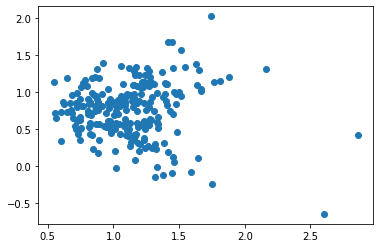

In [273]:
plt.scatter(full_df.horizontal_speed_avg, full_df.vert_vel_avg)

In [274]:
full_df.to_hdf('6.22.22_verticaltemporal.hdf', key='/windgps')

# Looking at all lagged dataframes

In [275]:
#t1=pd.read_hdf('10.20.20_verticaltemporal.hdf')
t2=pd.read_hdf('7.7.21_verticaltemporal.hdf')
t3=pd.read_hdf('9.26.21_verticaltemporal.hdf')
t4=pd.read_hdf('10.29.21_verticaltemporal.hdf')
t5=pd.read_hdf('10.30.21_verticaltemporal.hdf')
t6=pd.read_hdf('1.8.22_verticaltemporal.hdf')
t7=pd.read_hdf('1.11.22_verticaltemporal.hdf')
t8=pd.read_hdf('1.15.22_verticaltemporal.hdf')
t9=pd.read_hdf('4.30.22_verticaltemporal.hdf')
t10=pd.read_hdf('5.1.22_verticaltemporal.hdf')
t11=pd.read_hdf('5.2.22_verticaltemporal.hdf')
t12=pd.read_hdf('6.1.22_verticaltemporal.hdf')
t13=pd.read_hdf('6.3.22_verticaltemporal.hdf')
t14=pd.read_hdf('6.7.22_verticaltemporal.hdf')
t15=pd.read_hdf('6.8.22_verticaltemporal.hdf')
t16=pd.read_hdf('6.22.22_verticaltemporal.hdf')

In [281]:
alltemp=[t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15,t16]

In [282]:
allt1=pd.concat(alltemp)

In [283]:
allt1=allt1.reset_index(inplace=False)
allt1

,index,time,vert_vel_avg,horizontal_speed_avg,horizontal_dir_avg,vert_vel_std,horizontal_speed_std,horizontal_dir_std,environment,group,cos_horizontal_dir_avg,sin_horizontal_dir_avg
0,0,30.0,-0.158157,0.953000,274.113018,0.528246,0.676785,75.561104,0.4,2,0.071724,-0.997425
1,1,60.0,-0.850928,2.359933,147.672778,1.001268,0.880464,54.117951,0.4,2,-0.845008,0.534754
2,2,90.0,-0.322030,3.150956,263.681711,0.768715,1.276166,16.291358,0.4,2,-0.110052,-0.993926
3,3,120.0,0.026839,3.132542,280.854901,1.002992,1.472101,23.287051,0.4,2,0.188322,-0.982107
4,4,150.0,-0.752726,1.717373,204.833767,0.719319,0.713760,49.987862,0.4,2,-0.907530,-0.419987
...,...,...,...,...,...,...,...,...,...,...,...,...
5315,235,480.0,0.248138,1.296189,165.919994,1.037465,0.667021,48.161578,0.4,16,-0.969957,0.243277
5316,236,510.0,1.001576,1.499945,135.453677,0.644313,0.766266,36.234930,0.4,16,-0.712684,0.701486
5317,237,540.0,1.097230,1.263696,84.484945,0.761784,0.690703,67.787679,0.4,16,0.096107,0.995371
5318,238,570.0,0.750286,0.862300,162.946011,0.579636,0.543145,64.171546,0.4,16,-0.956029,0.293273


## plotting

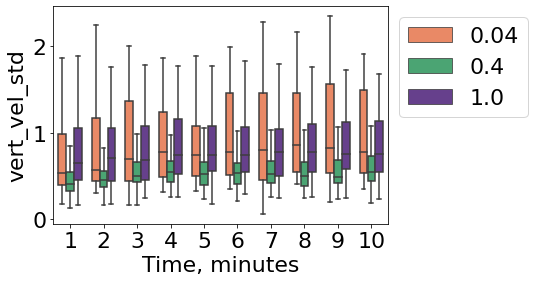

In [319]:
minutesdf=allt1.loc[allt1['time'].isin([60,120,180,240,300,360,420,480,540,600])]
fig, ax = plt.subplots()
sns.boxplot(x='time', y='vert_vel_std', hue='environment', data=minutesdf, showfliers=False, palette=['coral', 'mediumseagreen', 'rebeccapurple',], width=.7, ax=ax)    
ax.set_xticklabels([1,2,3,4,5,6,7,8,9,10])
ax.set_xlabel('Time, minutes')
ax.legend(bbox_to_anchor=(1,1))

(0.0, 90.0)

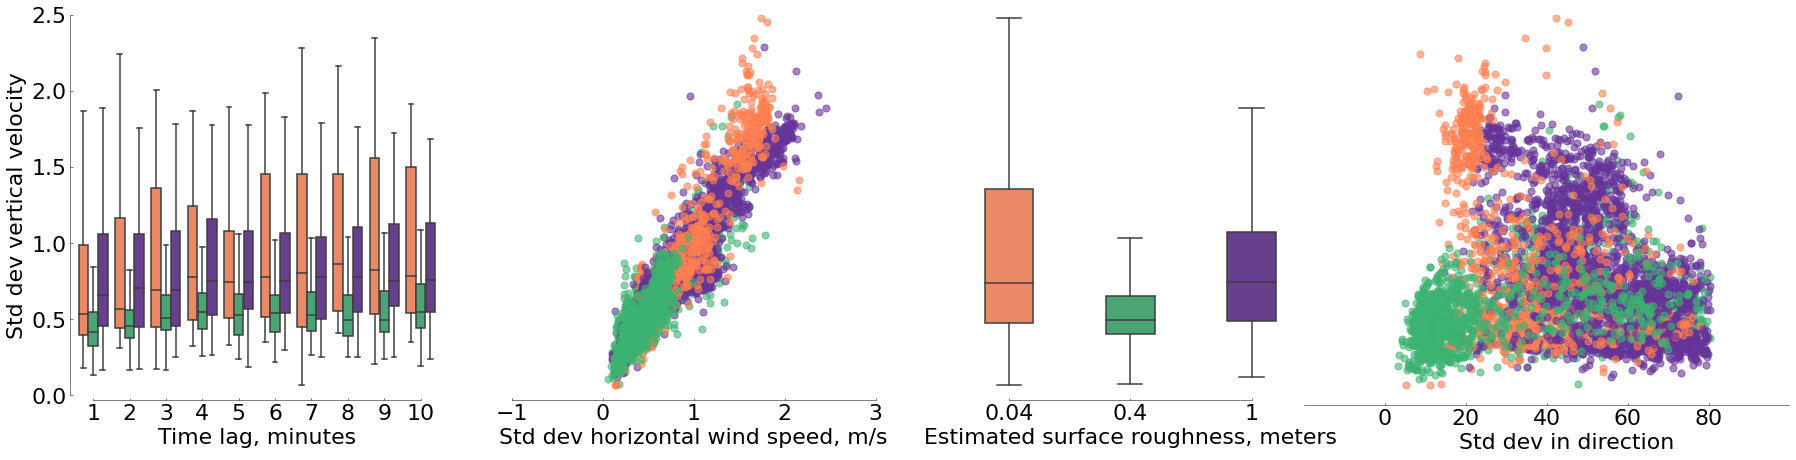

In [346]:
mpl.rcParams.update({'font.size': 22})

c=['mediumseagreen', 'rebeccapurple', 'mediumseagreen', 'rebeccapurple', 'rebeccapurple', 'coral', 'coral', 'rebeccapurple', 'rebeccapurple', 'rebeccapurple', 'coral', 'coral', 'mediumseagreen', 'mediumseagreen', 'mediumseagreen']

fig, ax =plt.subplots(nrows=1, ncols=4, figsize=(30,7))
alltemp=allt
#ax[1].scatter(alltemp[0].horizontal_speed_avg, np.abs(alltemp[0].vert_vel_std),  s=20, color=c[0], alpha=.6, label='desert/valley')
#ax[1].scatter(alltemp[1].horizontal_speed_avg, np.abs(alltemp[1].vert_vel_std),  s=20, color=c[1], alpha=.6, label='forest')
#ax[1].scatter(alltemp[2].horizontal_speed_avg, np.abs(alltemp[2].vert_vel_std),  s=20, color=c[2], alpha=.6, label='urban')

# add mean lines
#ax[1].plot(deserttemp.speed_avg, abline_values_desertdirection3, 'blue', linewidth=5)
#ax[1].plot(foresttemp.speed_avg, abline_values_forestdirection3, 'darkgreen',linewidth=5)
#ax[1].plot(urbantemp.speed_avg, abline_values_urbandirection3, 'indigo', linewidth=5)


for i in range(0,15):
    ax[1].scatter(alltemp[i].horizontal_speed_std, alltemp[i].vert_vel_std,  s=50, color=c[i],alpha=.6)
    ax[3].scatter(alltemp[i].horizontal_dir_std,alltemp[i].vert_vel_std,  s=50, color=c[i], alpha=.6)
    
#sns.boxplot(x='time', y='vert_vel_std', hue='environment', data=allt1, showfliers=False, palette=['steelblue', 'seagreen', 'purple',], width=.7, ax=ax[0])    
minutesdf=allt1.loc[allt1['time'].isin([60,120,180,240,300,360,420,480,540,600])]
#minutesdf['abs_ver_vel']=np.abs()
sns.boxplot(x=minutesdf.time, y=minutesdf.vert_vel_std, hue=minutesdf.environment, showfliers=False, palette=['coral', 'mediumseagreen', 'rebeccapurple',], width=.8, ax=ax[0])    
ax[0].set_xticklabels([1,2,3,4,5,6,7,8,9,10])
ax[0].set_xlabel('Time, minutes')
ax[0].legend(bbox_to_anchor=(3,1))

sns.boxplot(x=allt1.environment, y=allt1.vert_vel_std, showfliers=False, palette=['coral', 'mediumseagreen', 'rebeccapurple',], width=.4, ax=ax[2])

#xticks=np.arange(0,6300,300)
#ax[0].set_xticklabels(xticks)
ax[2].set_xticklabels([.04, .4, 1])
ax[0].set_ylabel('Std dev vertical velocity')
ax[0].set_xlabel('Time lag, minutes')  
ax[1].set_xlabel('Std dev horizontal wind speed, m/s')
ax[2].set_ylabel('')
ax[3].set_xlabel('Std dev in direction')
ax[2].set_xlabel('Estimated surface roughness, meters')
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)
ax[3].grid(False)

ax[0].set_ylim(0,2.5)
ax[1].set_ylim(0,2.5)
ax[2].set_ylim(0,2.5)
ax[3].set_ylim(0,2.5)

# Set log scale and spines

ax[0].set_facecolor('white')
ax[1].set_facecolor('white')
ax[2].set_facecolor('white')


fifi.mpl_functions.adjust_spines(ax[0], ['left', 'bottom'],
                                
                                 #xticks=[1,100,500,1000],
                                 tick_length=2.5,
                                 spine_locations={'left': 5, 'bottom': 5},
                                 linewidth=0.5)
fifi.mpl_functions.adjust_spines(ax[1], [ 'bottom'],
                                 #xticks=[0,90, 180, 270, 360],
                                 tick_length=2.5,
                                 spine_locations={'left': 5, 'bottom': 5},
                                 linewidth=0.5)
fifi.mpl_functions.adjust_spines(ax[2], [ 'bottom'],
                                 #xticks=[0,90, 180, 270, 360],
                                 tick_length=2.5,
                                 spine_locations={'left': 5, 'bottom': 5},
                                 linewidth=0.5)



# set yticklabels
#evenyticks = np.arange(0, 180+20, 20)
#yticklabels = [['$' + str(y) + '^{\circ}$', ''] for y in evenyticks]
#yticklabels = np.ravel(yticklabels)[0:-1]
#ax[0].set_yticklabels(yticklabels)

fifi.mpl_functions.adjust_spines(ax[3], [ 'bottom'],
                                 
                                 tick_length=2.5,
                                 spine_locations={ 'bottom': 10},
                                 linewidth=0.5)
ax[3].set_xlim(0,90)



# Regression analysis

In [ ]:
alltemporal=pd.read_hdf('all_temporal.hdf', key='/windgps')

In [353]:
alltemporal['abs_vert_vel_avg']=np.abs(alltemporal.vert_vel_avg)

In [354]:
#normalize pandas columns
N=len(alltemporal)+1
normalized_data = alltemporal.iloc[:,0:N].apply(lambda iterator: ((iterator - iterator.mean())/iterator.std()).round(7))

In [355]:
normalized_data

,index,time,vert_vel_avg,horizontal_speed_avg,horizontal_dir_avg,vert_vel_std,horizontal_speed_std,horizontal_dir_std,environment,group,cos_horizontal_dir_avg,sin_horizontal_dir_avg,abs_vert_vel_avg
0,-1.279830,-1.647354,0.308247,-0.633481,0.746243,-0.522097,-0.094130,1.700433,-0.579246,-1.729162,0.409932,-0.933101,-0.767332
1,-1.273745,-1.473948,-0.433619,0.574003,-0.763491,0.624037,0.357801,0.645445,-0.579246,-1.729162,-1.106915,1.275158,0.170687
2,-1.267661,-1.300543,0.132760,1.252889,0.621690,0.060561,1.235801,-1.215597,-0.579246,-1.729162,0.109161,-0.928059,-0.545446
3,-1.261576,-1.127137,0.506352,1.237085,0.826743,0.628214,1.670550,-0.871413,-0.579246,-1.729162,0.602858,-0.911025,-0.945137
4,-1.255491,-0.953731,-0.328457,0.022534,-0.080972,-0.059126,-0.012087,0.442248,-0.579246,-1.729162,-1.210366,-0.100867,0.037720
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5315,0.150134,0.953731,0.743334,-0.338943,-0.545614,0.711743,-0.115794,0.352396,-0.579246,1.554571,-1.313659,0.855065,-0.645496
5316,0.156219,1.127137,1.550165,-0.164072,-0.909391,-0.240866,0.104414,-0.234387,-0.579246,1.554571,-0.887968,1.515461,0.374666
5317,0.162304,1.300543,1.652597,-0.366829,-1.517973,0.043768,-0.063247,1.317986,-0.579246,1.554571,0.450277,1.939025,0.504181
5318,0.168388,1.473948,1.281067,-0.711323,-0.581125,-0.397578,-0.390656,1.140075,-0.579246,1.554571,-1.290613,0.927122,0.034417


In [358]:
mod = smf.gls(formula='vert_vel_std ~ environment*horizontal_speed_std + horizontal_speed_std*time + cos_horizontal_dir_avg +  sin_horizontal_dir_avg', data=normalized_data)
res = mod.fit(cov_type='cluster', cov_kwds={'groups': alltemporal.group})
#res=mod.fit()
print(res.summary())

                            GLS Regression Results                            
Dep. Variable:           vert_vel_std   R-squared:                       0.882
Model:                            GLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     317.1
Date:                Sun, 18 Sep 2022   Prob (F-statistic):           2.54e-14
Time:                        20:39:38   Log-Likelihood:                -1874.0
No. Observations:                5320   AIC:                             3764.
Df Residuals:                    5312   BIC:                             3817.
Df Model:                           7                                         
Covariance Type:              cluster                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

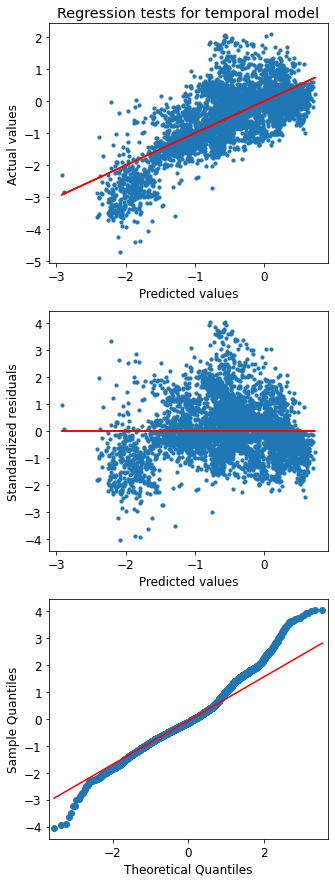

In [377]:
mod = smf.ols(formula='vert_vel_avg ~ environment*horizontal_speed_std + horizontal_speed_std*time + cos_horizontal_dir_avg +  sin_horizontal_dir_avg', data=alltemporal)
res = mod.fit(cov_type='cluster', cov_kwds={'groups': alltemporal.group})
mpl.rcParams.update({'font.size': 12})

fig, ax =plt.subplots(nrows=3, ncols=1, figsize=(5,15))


slope, intercept = np.polyfit(res.fittedvalues, alltemporal.vert_vel_avg, 1)
abline_values = [slope * i + intercept for i in res.fittedvalues]

ax[0].set_title('Regression tests for temporal model')
ax[0].scatter(res.fittedvalues, alltemporal.vert_vel_avg, s=10)
ax[0].plot(res.fittedvalues, abline_values, 'r')
ax[0].set_xlabel ('Predicted values')
ax[0].set_ylabel ('Actual values')
#ax[0].set_xlim(-5,90)
#ax[0].set_ylim(-5,90)

slope, intercept = np.polyfit(res.fittedvalues, res.resid_pearson, 1)
abline_values = [slope * i + intercept for i in res.fittedvalues]

ax[1].scatter(res.fittedvalues, res.resid_pearson, s=10)
ax[1].plot(res.fittedvalues, abline_values, 'r')
ax[1].set_xlabel ('Predicted values')
ax[1].set_ylabel ('Standardized residuals')


sm.qqplot(res.resid_pearson, line='q', ax=ax[2])
plt.show()
